In [1]:
import pandas as pd
import numpy as np
from math import sin, cos, sqrt, atan2, radians
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from random import choice
from scipy.stats import randint as sp_randint
import gc
from sklearn.model_selection import TimeSeriesSplit, KFold
pd.options.display.max_columns = None
%matplotlib inline

/Users/antoncabanec/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))
data = pd.read_csv('full_data.csv')

In [3]:
test = pd.read_csv('test.csv')

In [4]:
labelencoder = LabelEncoder()
data["city"] = labelencoder.fit_transform(data["city"].values.astype('str'))
data['city_type'] = labelencoder.fit_transform(data['city_type'].values.astype('str'))
data['atm_group'] = labelencoder.fit_transform(data['atm_group'].values.astype('str'))
data['dbcluster'] = labelencoder.fit_transform(data['dbcluster'].values.astype('str'))

In [5]:
X = data[data.isTrain == True].drop(['address', 'address_rus', 'isTrain', 'target'], 1)
Y = data[data.isTrain == True][['target']]
X_test = data[data.isTrain == False].drop(['address', 'address_rus', 'isTrain', 'target'], 1)

In [6]:
n_iterations = 20 # number of iterations for random search
top_n = 15 # select top n parameter sets

rmse_mean = []
rmse_std = []
dict_list = []
# prepare indexes for stratified cross validation
skf = KFold(n_splits=5, shuffle=False)
skf.get_n_splits(X, Y)

5

In [7]:
# loop for random search

print ("Random search start...")
print ("")

for i in range(0, n_iterations):
    skf_split = skf.split(X, Y)
    param_dist = {'num_leaves': choice([8, 16, 27, 31, 61, 127, 255, 511, 1023, 2047, 4095]),
              'feature_fraction': choice([0, 0.3, 0.5, 0.7, 1]),
              'bagging_fraction': choice([0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 1]),
              'min_data_in_bin': choice([1, 3, 5, 10, 15, 20]),
              'min_sum_hessian_in_leaf': choice([1, 5, 10, 20]),
              'learning_rate': choice([0.001, 0.005, 0.01, 0.05, 0.1, 0.03, 0.05, 0.3]),
              'min_data': choice([50,100, 200, 300, 400, 450, 500, 550, 650]),
              'max_bin': choice([3, 5, 7, 10, 12, 18, 20, 22]),
              'boosting_type' : choice(['gbdt', 'dart']),
              'bagging_freq': choice([3, 5, 7, 9, 11, 15, 17, 23, 31]),
              'max_depth': choice([3, 4, 5, 6, 7, 8, 9, 10, 11, 15]),       
              'feature_fraction': choice([0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 1]),
              'lambda_l1': choice([0, 1, 3, 5, 10, 20, 30, 40]),
              'objective': 'regression', 
              'metric': 'rmse'} 
    
    rmse_metric = []
    
    print ("Cycle {}...".format(i+1))
    for train_index, test_index in skf_split:
    
        X_train = X.iloc[train_index]
        y_train = Y.iloc[train_index]
    
        X_val = X.iloc[test_index]
        y_val = Y.iloc[test_index]
    
        # training
        lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=True)
        lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train, free_raw_data=True)
    
        gbm = lgb.train(param_dist,
                        lgb_train,
                        num_boost_round = 1000,
                        valid_sets = lgb_val,
                        early_stopping_rounds=25,
                        verbose_eval=100)
        # predicting
        y_pred = gbm.predict(X_val, num_iteration=gbm.best_iteration)
        
        rmse_i = rmse(y_val, y_pred)
        rmse_metric.append(rmse_i)

    rmse_array = np.asarray(rmse_metric)
    
    rmse_mean.append(rmse_array.mean())
    rmse_std.append(rmse_array.std())
    dict_list.append(param_dist)
    gc.collect()

results_pd = pd.DataFrame({"rmse_mean": rmse_mean,
                           "rmse_std": rmse_std,
                           "parameters": dict_list})

Random search start...

Cycle 1...
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[20]	valid_0's rmse: 0.0555651
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[26]	valid_0's rmse: 0.0525328
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[26]	valid_0's rmse: 0.0527631
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[26]	valid_0's rmse: 0.0540695
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[26]	valid_0's rmse: 0.0538304
Cycle 2...
Training until validation scores don't improve for 25 rounds.
[100]	valid_0's rmse: 0.0489377
[200]	valid_0's rmse: 0.0484315
[300]	valid_0's rmse: 0.0484313
[400]	valid_0's rmse: 0.0484313
[500]	valid_0's rmse: 0.0484313
[600]	valid_0's rmse: 0.0484313
[700]	valid_0's rmse: 0.0484313
Early stopping, best iterati

In [8]:
z = results_pd.sort_values('rmse_mean').copy().reset_index()
print("Minimum mean RMSE : ", z.rmse_mean.min(), "\nAnd the parameters list is : \n", z.parameters[0])

Minimum mean RMSE :  0.04692331776539688 
And the parameters list is : 
 {'num_leaves': 16, 'feature_fraction': 0.7, 'bagging_fraction': 0.9, 'min_data_in_bin': 15, 'min_sum_hessian_in_leaf': 10, 'learning_rate': 0.05, 'min_data': 500, 'max_bin': 20, 'boosting_type': 'gbdt', 'bagging_freq': 17, 'max_depth': 3, 'lambda_l1': 3, 'objective': 'regression', 'metric': 'rmse'}


In [9]:
#params = {'num_leaves': 16, 'feature_fraction': 0.7, 'bagging_fraction': 0.9, 'min_data_in_bin': 15, 
#          'min_sum_hessian_in_leaf': 10, 'learning_rate': 0.05, 'min_data': 500, 'max_bin': 20, 
#           'boosting_type': 'gbdt', 'bagging_freq': 17, 'max_depth': 3, 'lambda_l1': 3,
#           'objective': 'regression', 'metric': 'rmse'}
params = z.parameters[0]
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=False, random_state=42)
# Cleaning and defining parameters for LGBM
model = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)

In [10]:
prediction = np.zeros(X_test.shape[0])

for fold_n, (train_index, test_index) in enumerate(folds.split(X)):
    print('Fold:', fold_n)
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_valid = Y.iloc[train_index], Y.iloc[test_index]

    model.fit(X_train, Y_train, 
            eval_set=[(X_train, Y_train), (X_valid, Y_valid)], eval_metric='rmse',
            verbose=500, early_stopping_rounds=100)
    
    y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
    prediction += y_pred
prediction /= n_fold

Fold: 0
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[261]	training's rmse: 0.0457342	valid_1's rmse: 0.0482493
Fold: 1
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 0.0461731	valid_1's rmse: 0.0456108
Early stopping, best iteration is:
[451]	training's rmse: 0.0461794	valid_1's rmse: 0.0456105
Fold: 2
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 0.0458966	valid_1's rmse: 0.0462623
Early stopping, best iteration is:
[406]	training's rmse: 0.0458975	valid_1's rmse: 0.0462614
Fold: 3
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[338]	training's rmse: 0.0460163	valid_1's rmse: 0.046218
Fold: 4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[385]	training's rmse: 0.0454843	valid_1's rmse: 0.0481885


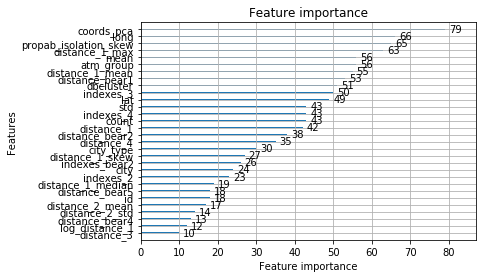

In [11]:
lgb.plot_importance(model, max_num_features=30)

In [12]:
submission = pd.DataFrame(prediction, index=test.index, columns=['target'])

In [13]:
submission.reset_index(level=0, inplace=True)
submission.index.name = ""
submission.to_csv('lgb_submit.csv',index=False)

In [15]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.25, random_state=1)

In [16]:
gbm = lgb.LGBMRegressor(objective = 'regression',  
                            max_depth = 3,
                            colsample_bytre = 0.8,
                            subsample = 0.8, 
                            learning_rate = 0.1,
                            n_estimators = 30000)

In [17]:
gbm.fit(X_train, Y_train, eval_set=[(X_valid, Y_valid)], eval_metric='rmse', early_stopping_rounds=50)

[1]	valid_0's rmse: 0.0790925	valid_0's l2: 0.00625562
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.0742903	valid_0's l2: 0.00551904
[3]	valid_0's rmse: 0.0701349	valid_0's l2: 0.00491891
[4]	valid_0's rmse: 0.0665312	valid_0's l2: 0.00442641
[5]	valid_0's rmse: 0.063494	valid_0's l2: 0.00403148
[6]	valid_0's rmse: 0.0609422	valid_0's l2: 0.00371395
[7]	valid_0's rmse: 0.0587009	valid_0's l2: 0.00344579
[8]	valid_0's rmse: 0.0568008	valid_0's l2: 0.00322633
[9]	valid_0's rmse: 0.0551742	valid_0's l2: 0.00304419
[10]	valid_0's rmse: 0.0538593	valid_0's l2: 0.00290082
[11]	valid_0's rmse: 0.0527321	valid_0's l2: 0.00278067
[12]	valid_0's rmse: 0.0517598	valid_0's l2: 0.00267908
[13]	valid_0's rmse: 0.0509299	valid_0's l2: 0.00259386
[14]	valid_0's rmse: 0.0502772	valid_0's l2: 0.0025278
[15]	valid_0's rmse: 0.0496464	valid_0's l2: 0.00246476
[16]	valid_0's rmse: 0.0491529	valid_0's l2: 0.00241601
[17]	valid_0's rmse: 0.0487459	valid_0's l2: 0.002376

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytre=0.8,
       colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
       max_depth=3, min_child_samples=20, min_child_weight=0.001,
       min_split_gain=0.0, n_estimators=30000, n_jobs=-1, num_leaves=31,
       objective='regression', random_state=None, reg_alpha=0.0,
       reg_lambda=0.0, silent=True, subsample=0.8,
       subsample_for_bin=200000, subsample_freq=0)

In [18]:
rmse(Y_valid, gbm.predict(X_valid))

0.04499226214211021

In [19]:
rmse(Y_valid, np.zeros(Y_valid.shape[0]))

0.08463725683992336

In [22]:
submit = pd.DataFrame(gbm.predict(X_test), index=test.index,columns=['target'])
submit.reset_index(level=0, inplace=True)
submit.index.name = ""
submit.to_csv('simple_lgb_submit.csv')

In [23]:
submit

,index,target
,,
0,0,-0.025831
1,1,-0.048605
2,2,-0.002872
3,3,-0.034140
4,4,0.008871
5,5,-0.021381
6,6,-0.018675
7,7,-0.067693
8,8,-0.038082
